In [50]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
# TSS_pre = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['4']:
#             TSS_pre.append(TSS(ll[0], int(ll[1])+int(1000)))

# TSS_NonGene = []
# with open(dic['non_gene_4'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))

# bamfile = ps.AlignmentFile(dic['bam4'],'rb')

# TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

# TSSes_x = TSS_HK + TSS_NonGene
# TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
# perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
# TSSes_x = np.array(TSSes_x)
# TSSes_y = np.array(TSSes_y)
# data_x = TSSes_x[perm[:len(perm)]]
# data_y = TSSes_y[perm[:len(perm)]]
up = 1000
down = 1000

In [51]:
# TSS_pre = []
# with open(dic['ATAC_hema_2'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_pre.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))

bamfile = ps.AlignmentFile(dic['bam4'],'rb')

TSS_pre = []
with open(dic['ATAC_Bcell'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['4'] and ll[2] == '5':
            TSS_pre.append(TSS(ll[0],int(ll[1])))
TSS_pre = TSS_pre[:1000]
# print(len(TSS_pre))
data_y = np.array([1]*len(TSS_pre))

In [52]:
'''lstm_input'''

feature_matrix = []
for j, tss in enumerate(TSS_pre):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            # ss = max(0, r.reference_start - start)
            # ee = min(r.reference_start - start + abs(r.isize), end - start)
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        wps = 0
        for r in bamfile.fetch(chrom[-1], ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)



In [53]:
print(lstm_x.shape)

(38, 50, 4)


(989, 100, 4)


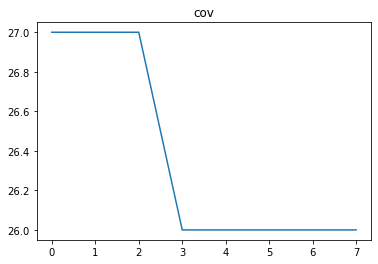

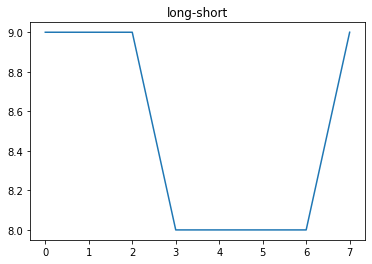

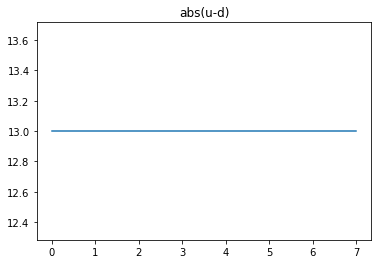

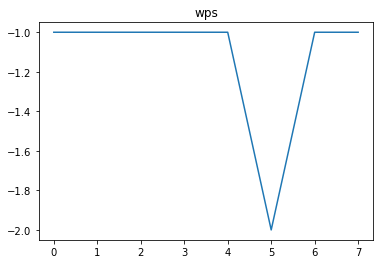

In [26]:
feature_matrix = np.array(feature_matrix)
print(feature_matrix.shape)
# print(feature_matrix.shape)
fff1 = np.zeros((8,4),dtype=int)
for i in range(8):
    for j in range(4):
        fff1[i][j] = np.mean([feature_matrix[k][i][j] for k in range(369)])
plt.plot([x for x in range(8)],fff1[:,0])
plt.title('cov')
plt.show()
plt.plot([x for x in range(8)],fff1[:,1])
plt.title('long-short')
plt.show()
plt.plot([x for x in range(8)],fff1[:,2])
plt.title('abs(u-d)')
plt.show()
plt.plot([x for x in range(8)],fff1[:,3])
plt.title('wps')
plt.show()

In [54]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSS_pre):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)

In [55]:
from keras.models import load_model
from tensorflow import keras
model = load_model('./conv_lstm.h5')
pred = np.array(model.predict([cnn_x, lstm_x]))
print(pred)
# pred = np.reshape(pred,(1,116))[0]
# pred = sorted(pred)
# k = []
# for i in range(len(pred)):
#     if pred[i][0] < 0.1:
#         k.append(i)
# print(k)


[[0.5008925 ]
 [0.56123793]
 [0.4452558 ]
 [0.43488136]
 [0.67045397]
 [0.53267854]
 [0.32725757]
 [0.5724421 ]
 [0.63423383]
 [0.3542108 ]
 [0.4420085 ]
 [0.36721134]
 [0.5408595 ]
 [0.47120535]
 [0.5315007 ]
 [0.46411672]
 [0.560888  ]
 [0.54445004]
 [0.4522993 ]
 [0.54839826]
 [0.5871287 ]
 [0.4624167 ]
 [0.45941567]
 [0.5695034 ]
 [0.45382568]
 [0.5152242 ]
 [0.3332575 ]
 [0.45498362]
 [0.539601  ]
 [0.49188668]
 [0.4472459 ]
 [0.28317156]
 [0.47622007]
 [0.45278788]
 [0.62287384]
 [0.51014245]
 [0.53751373]
 [0.4926699 ]]


In [176]:
pred = np.reshape(pred,(1,116))[0]
pred = sorted(pred)
print(pred)

[0.005488187, 0.009262681, 0.0099333525, 0.023839593, 0.053055644, 0.08173603, 0.11069217, 0.2358343, 0.26383606, 0.38317466, 0.46479905, 0.4855758, 0.50437665, 0.6095272, 0.6640078, 0.68901986, 0.7000742, 0.78032523, 0.79086477, 0.79256254, 0.79708946, 0.8112696, 0.81941986, 0.8440914, 0.8566028, 0.90164906, 0.91457, 0.92743367, 0.9307195, 0.9427336, 0.9440104, 0.9483211, 0.94976896, 0.9503901, 0.95366573, 0.9572027, 0.9582278, 0.9614352, 0.963107, 0.9646502, 0.9686763, 0.9697317, 0.97123814, 0.9719397, 0.9727506, 0.9728269, 0.9748734, 0.9753658, 0.97695184, 0.97921455, 0.9797579, 0.9801029, 0.9805725, 0.98073345, 0.9809427, 0.9814032, 0.9830141, 0.9842936, 0.98525, 0.98542345, 0.9855644, 0.98592234, 0.98598456, 0.9863391, 0.98634356, 0.9864414, 0.98683715, 0.98712385, 0.98795235, 0.98813534, 0.98945904, 0.9905268, 0.99058145, 0.9906442, 0.9915856, 0.9925667, 0.992838, 0.99288315, 0.9932924, 0.99377596, 0.9938952, 0.993911, 0.9940605, 0.99457234, 0.99492574, 0.9954357, 0.9955369, 0.99

In [142]:
from keras.models import load_model
from tensorflow import keras
model = load_model('./conv_lstm.h5')
pred = np.array(model.predict([cnn_x, lstm_x]))
pre = []
for pp in pred:
    if pp[0] < pp[1]:
        pre.append(1)
    else:
        pre.append(0)
from sklearn import metrics
num = len(data_y)
accuracy = len([1 for i in range(num) if data_y[i] == pre[i]]) / float(num)
print("acc:",accuracy)
# tn,fp,fn,tp = metrics.confusion_matrix(pre, data_y,labels=[0,1]).ravel()
# print('sensitivity:',tp/(tp+fn))
# print('specificity:',tn/(tn+fp))

IndexError: index 1 is out of bounds for axis 0 with size 1

/home/jiay/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


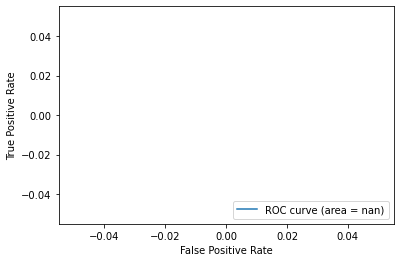

In [137]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout
from keras.models import Model, load_model
from tensorflow import keras
from sklearn import metrics

model = load_model('./conv_lstm.h5')
pred = np.array(model.predict([cnn_x, lstm_x]))
fpr, tpr, thresholds = metrics.roc_curve(data_y, pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()